# Import Package

In [1]:
import numpy as np
import pandas as pd 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Import Dataset

In [32]:
rating = pd.read_csv('/content/kuliner_rating.csv')
kuliner = pd.read_csv('/content/Kuliner_dataset_bali.csv')
user = pd.read_csv('/content/user.csv')

In [34]:
# melihat ukuran data
print(f'rating : {rating.shape}')
print(f'kuliner : {kuliner.shape}')
print(f'user : {user.shape}')

rating : (10000, 3)
kuliner : (50, 7)
user : (300, 3)


# Persiapan Dataset

In [35]:
rating.head()

,User_Id,Place_Id,Place_Ratings
0,1,13,3
1,1,15,2
2,1,21,5
3,1,12,3
4,1,23,4


In [7]:
# membuang kolom unnamed
# rating = rating.drop(columns='Unnamed: 0')
# rating.head()

In [36]:
user.head()

,User_Id,Location,Age
0,1,"Semarang, Jawa Tengah",20
1,2,"Bekasi, Jawa Barat",21
2,3,"Cirebon, Jawa Barat",23
3,4,"Bekasi, Jawa Barat",21
4,5,"Lampung, Sumatera Selatan",20


In [37]:
df = rating.copy()

In [38]:
#ENCODING
def dict_encoder(col, data=df):
  unique_val = data[col].unique().tolist()
  val_to_val_encoded = {x: i for i, x in enumerate(unique_val)}
  val_encoded_to_val = {i: x for i, x in enumerate(unique_val)}
  return val_to_val_encoded, val_encoded_to_val

In [39]:
user_to_user_encoded, user_encoded_to_user = dict_encoder('User_Id')
df['user'] = df['User_Id'].map(user_to_user_encoded)

In [40]:
# Encoding Place_Id
place_to_place_encoded, place_encoded_to_place = dict_encoder('Place_Id')

# Mapping Place_Id ke dataframe place
df['place'] = df['Place_Id'].map(place_to_place_encoded)

In [41]:
# Mendapatkan jumlah user dan hotel
num_users, num_place = len(user_to_user_encoded), len(place_to_place_encoded)
# mengubah nilai rating menjadi nilai float
df['Place_Ratings'] = df['Place_Ratings'].values.astype(np.float32)
# Mendapatkan nilai minimum dan maksimum rating
min_rating, max_rating = min(df['Place_Ratings']), max(df['Place_Ratings'])


In [43]:
print(f'Jumlah user : {num_users}')
print(f'Jumlah Kuliner : {num_place}')
print(f'Rating minimum : {min_rating}')
print(f'Rating maximum : {max_rating}')

Jumlah user : 300
Jumlah Kuliner : 49
Rating minimum : 1.0
Rating maximum : 5.0


In [44]:
# Mengacak dataset
df = df.sample(frac=1, random_state=42)
df.head()

,User_Id,Place_Id,Place_Ratings,user,place
6252,188,16,3.0,187,16
4684,142,4,2.0,141,46
1731,54,26,3.0,53,25
4742,144,49,3.0,143,31
4521,138,6,5.0,137,45


# Splitting Dataset

In [45]:
# Mambuat Variable x
x = df[['user', 'place']].values
# membuat Variable y
y = df['Place_Ratings'].apply(lambda x: (x-min_rating)/(max_rating-min_rating)).values

# split dataset
indices = int(0.8*df.shape[0])
x_train, x_test, y_train, y_test = (x[:indices],
                                    x[indices:],
                                    y[:indices],
                                    y[indices:]
                                    )
print(f'x_train : {x_train.shape}')
print(f'x_test : {x_test.shape}')
print(f'y_train : {y_train.shape}')
print(f'y_test : {y_test.shape}')

x_train : (8000, 2)
x_test : (2000, 2)
y_train : (8000,)
y_test : (2000,)


 # Membuat model

In [46]:
class Recommended(keras.Model):
  def __init__(self,num_users, num_places, embedding_size, **kwargs):
    super(Recommended, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_places = num_places
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding(num_users,
                                           embedding_size,
                                           embeddings_initializer = 'he_normal',
                                           embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users,1)
    self.places_embedding = layers.Embedding(num_places,
                                             embedding_size,
                                             embeddings_initializer='he_normal',
                                             embeddings_regularizer= keras.regularizers.l2(1e-6)
                                             )
    self.places_bias = layers.Embedding(num_places,1)

  def call(self, inputs):
    user_vec = self.user_embedding(inputs[:,0])
    user_bias = self.user_bias(inputs[:,0])
    places_vec = self.places_embedding(inputs[:,1])
    places_bias = self.places_bias(inputs[:,1])

    dot_user_places = tf.tensordot(user_vec, places_vec, 2)

    x = dot_user_places + user_bias + places_bias

    return tf.nn.sigmoid(x)


In [47]:
model = Recommended(num_users, num_place, 50)

model.compile(loss = keras.losses.BinaryCrossentropy(),
              optimizer= keras.optimizers.Adam(learning_rate=0.0004),
              metrics=[keras.metrics.RootMeanSquaredError()]
              )

# training Model

In [48]:
history = model.fit(
    x = x_train,
    y = y_train,
    epochs = 100,
    validation_data = (x_test, y_test)
)

Epoch 1/100
250/250 [==============================] - 2s 4ms/step - loss: 0.7430 - root_mean_squared_error: 0.3754 - val_loss: 0.7367 - val_root_mean_squared_error: 0.3706
Epoch 2/100
250/250 [==============================] - 1s 3ms/step - loss: 0.7295 - root_mean_squared_error: 0.3681 - val_loss: 0.7358 - val_root_mean_squared_error: 0.3705
Epoch 3/100
250/250 [==============================] - 1s 3ms/step - loss: 0.7304 - root_mean_squared_error: 0.3689 - val_loss: 0.7321 - val_root_mean_squared_error: 0.3684
Epoch 4/100
250/250 [==============================] - 1s 3ms/step - loss: 0.7247 - root_mean_squared_error: 0.3652 - val_loss: 0.7316 - val_root_mean_squared_error: 0.3684
Epoch 5/100
250/250 [==============================] - 1s 3ms/step - loss: 0.7229 - root_mean_squared_error: 0.3641 - val_loss: 0.7282 - val_root_mean_squared_error: 0.3665
Epoch 6/100
250/250 [==============================] - 1s 3ms/step - loss: 0.7200 - root_mean_squared_error: 0.3625 - val_loss: 0.7274 

# Evaluasi Model

In [49]:
model.evaluate(x=x_test, y=y_test)

63/63 [==============================] - 0s 2ms/step - loss: 0.7074 - root_mean_squared_error: 0.3545


[0.7074306607246399, 0.3545437753200531]

# PLotting hasil training

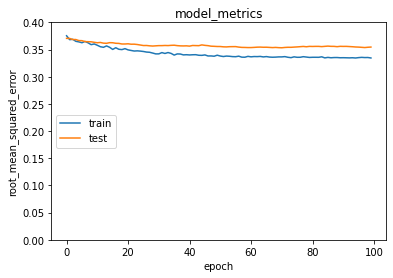

In [50]:
import matplotlib.pyplot as plt

plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.ylim(ymin=0, ymax=0.4)
plt.legend(['train', 'test'], loc='center left')
plt.show()

# Contoh Penerapan Model

In [51]:
kuliner.columns

Index(['Id', 'Name', 'Ratings', 'Addres', 'Coordinate', 'Lat', 'Long'], dtype='object')

In [52]:
place_df = kuliner[['Id', 'Name', 'Ratings', 'Addres', 'Coordinate', 'Lat', 'Long']]
place_df.columns = ['Id', 'Name', 'Ratings', 'Addres', 'Coordinate', 'Lat', 'Long']
df = rating.copy()

In [53]:
# Mengambil sample user
user_id = df.User_Id.sample(1).iloc[0]
place_visited_by_user = df[df.User_Id == user_id]

In [54]:
# Membuat data lokasi yang belum dikunjungi user
place_not_visited = place_df[~place_df['Id'].isin(place_visited_by_user.Place_Id.values)]['Id'] 
place_not_visited = list(
    set(place_not_visited).intersection(set(place_to_place_encoded.keys()))
)
 
place_not_visited = [[place_to_place_encoded.get(x)] for x in place_not_visited]
user_encoder = user_to_user_encoded.get(user_id)
user_place_array = np.hstack(
    ([[user_encoder]] * len(place_not_visited), place_not_visited)
)

In [55]:
# Mengambil top 5 recommendation
ratings = model.predict(user_place_array).flatten()
top_ratings_indices = ratings.argsort()[-5:][::-1]
recommended_place_ids = [
    place_encoded_to_place.get(place_not_visited[x][0]) for x in top_ratings_indices
]
 

print('')
print('----' * 15)
print('Top 5 place recommendation')
print('----' * 15)
 
recommended_place = place_df[place_df['Id'].isin(recommended_place_ids)]
for row, i in zip(recommended_place.itertuples(), range(1,8)):
    print(i,'.', row.Name, '\n    ', row.Addres, ',', 'Rating Kuliner ', row.Ratings,'\n')

print('==='*15)


------------------------------------------------------------
Top 5 place recommendation
------------------------------------------------------------
1 . Makan Place 
     Jl. Padma No.1, Legian, Kec. Kuta, Kabupaten Badung, Bali 80361 , Rating Kuliner  4.4 

2 . Restoran Renon 
     Jl. Cok Agung Tresna No.85, Sumerta Kelod, Kec. Denpasar Tim., Kota Denpasar, Bali 80239 , Rating Kuliner  4.5 

3 . Ayam Bakar Taliwang Baru 
     Jl. Teuku Umar No.8, Dauh Puri Kauh, Kec. Denpasar Bar., Kota Denpasar, Bali 80113 , Rating Kuliner  4.4 

4 . Bebek Tepi Sawah Nusa Dua 
     Kawasan BTDC Area Bali Collection, Nusa Dua, Benoa, Kec. Kuta Sel., Kabupaten Badung, Bali 80363 , Rating Kuliner  4.2 

5 . Sate Babi Bawah Pohon 
     Jalan Dewi Sri IV Campuhan I No.I, Legian, Kec. Kuta, Kabupaten Badung, Bali 80361 , Rating Kuliner  4.5 



# Save Model

In [56]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model_kuliner_bali.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpp2vtbtqy/assets


INFO:tensorflow:Assets written to: /tmp/tmpp2vtbtqy/assets
